In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
39268,NaN,NaN,International,2020-08-22,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39269,NaN,NaN,International,2020-08-23,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39270,NaN,NaN,International,2020-08-24,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


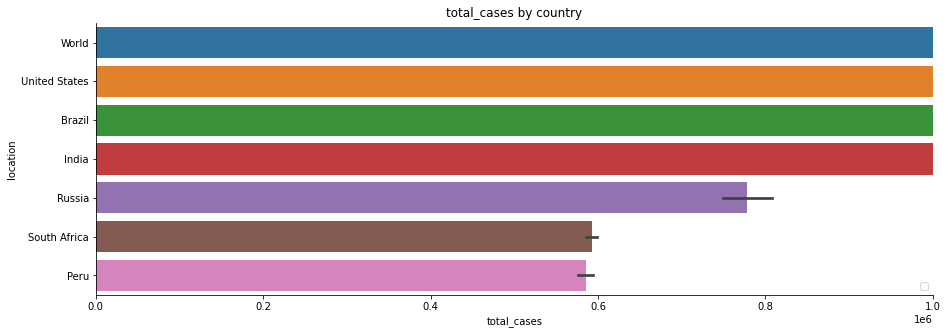

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


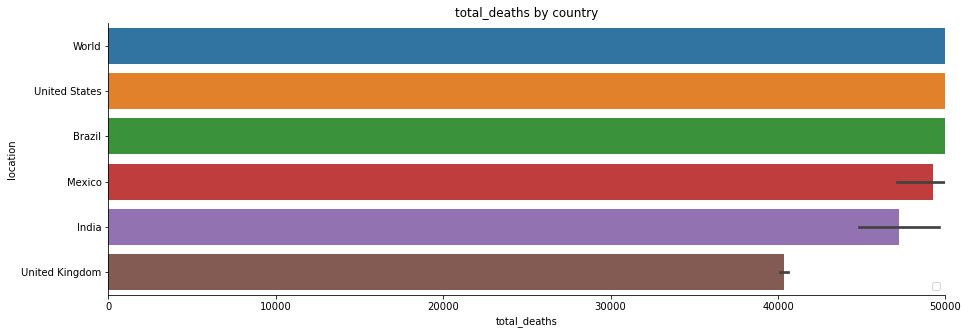

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


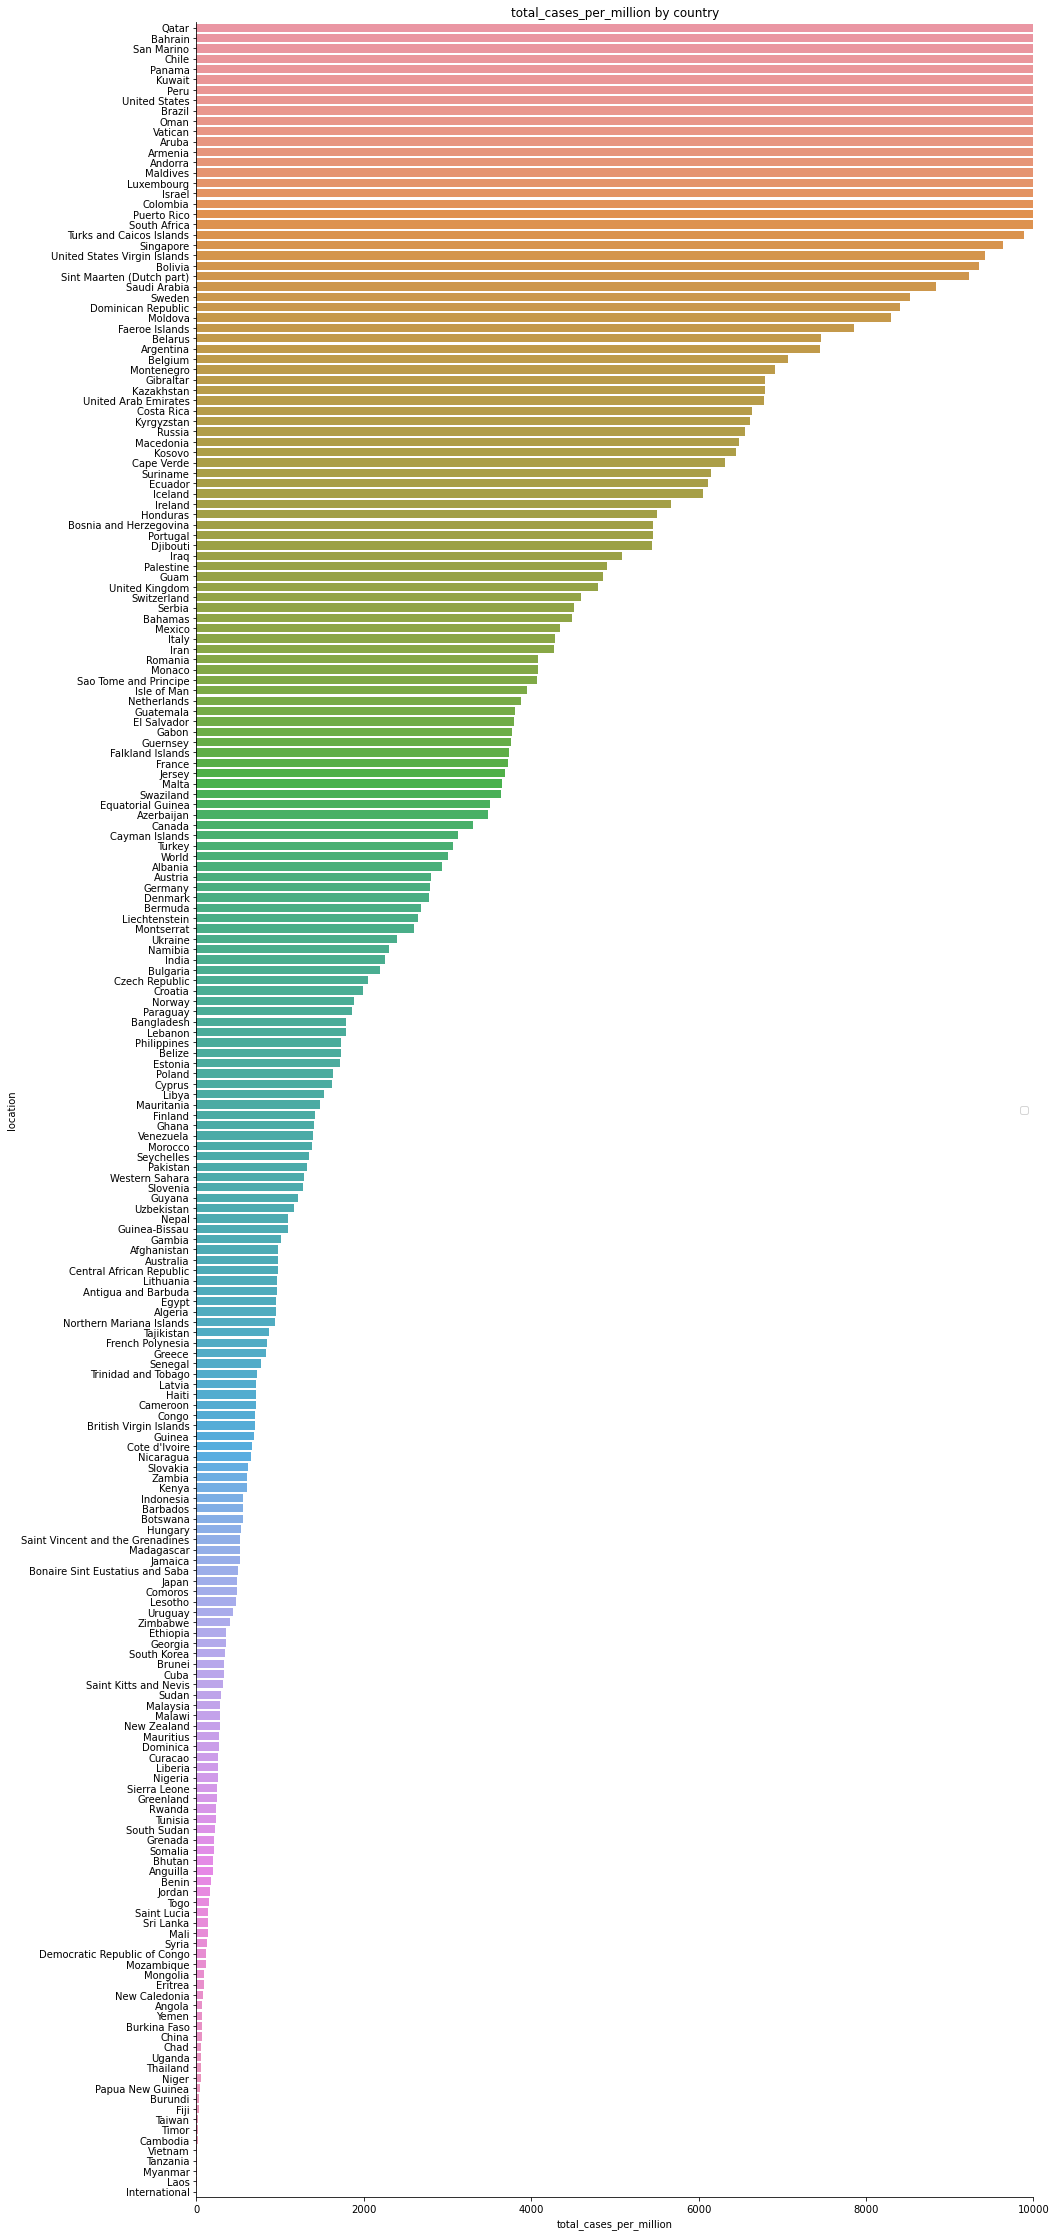

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


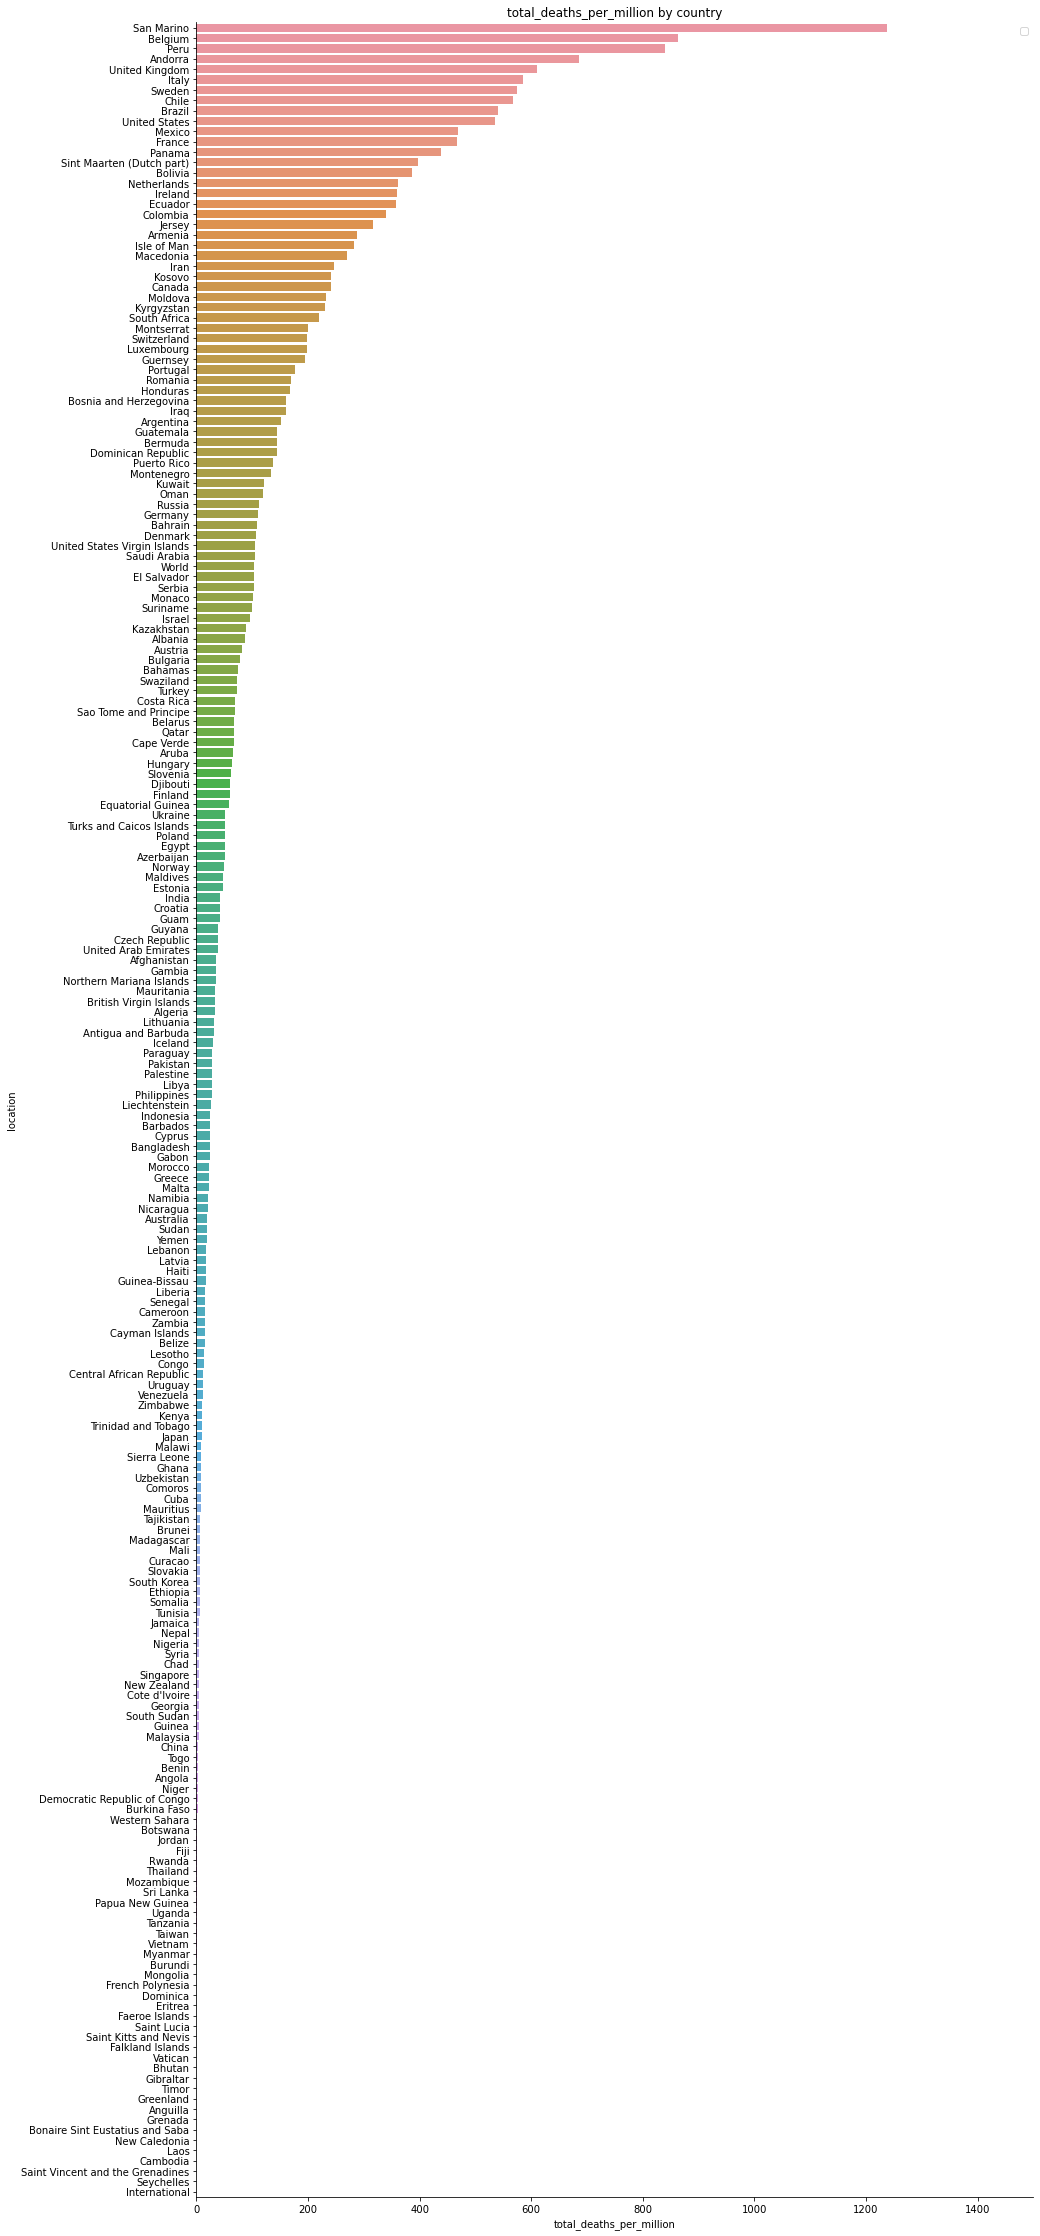

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

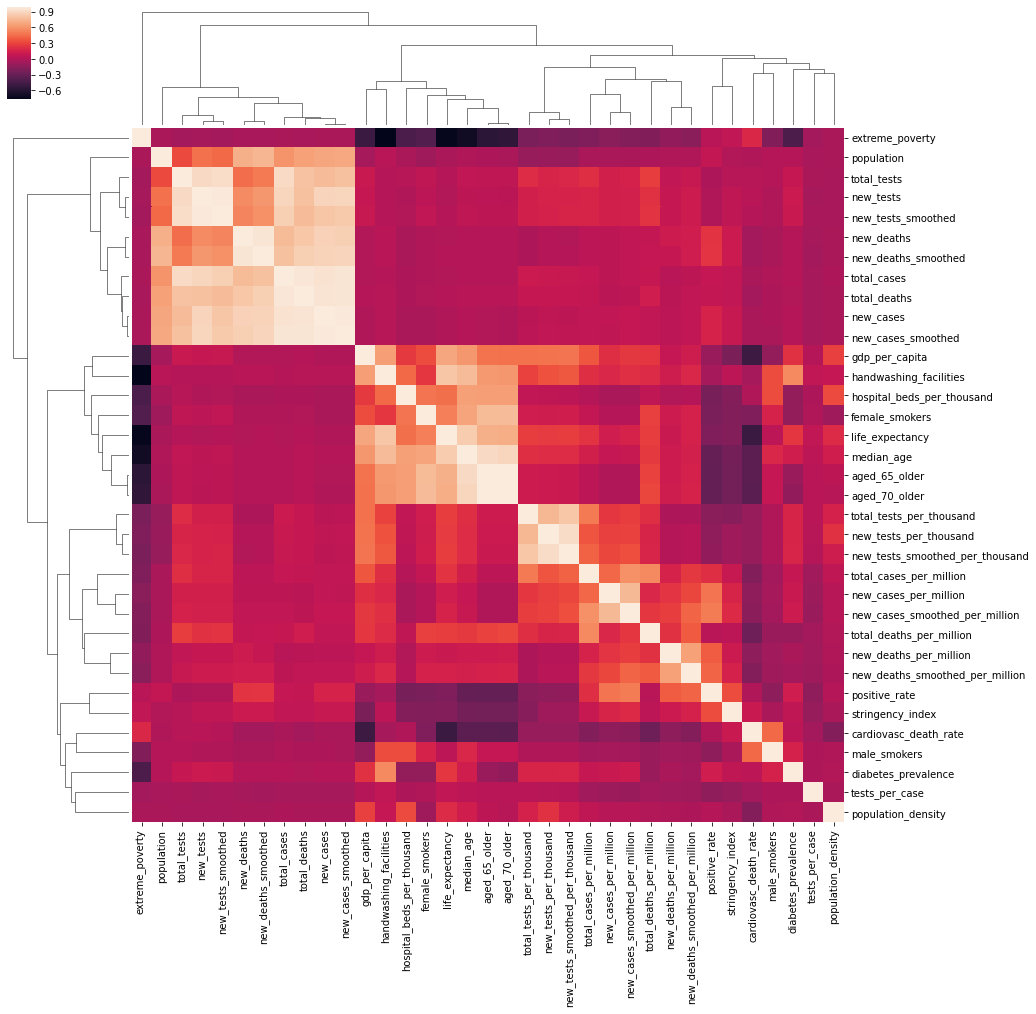

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.99951732265882 (+/- 0.00031515283021135357)
Coef :  [1.04003491e+00 8.78352148e-05 9.22401401e-05]
3 Last_days :  [[22970240 23236330 23441581]]
Today :  23441581
Prediction + :  526666
Tomorow :  23968247
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996269658156248 (+/- 3.364309738001104e-05)
Coef :  [-0.01888252  0.49739479  0.53163579]
3 Last_days :  [[800060 805690 809422]]
Today :  809422
Prediction + :  8876
Tomorow :  818298
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.994217372832984 (+/- 0.001455975145888821)
Coef :  [-0.6827351   0.73895401  0.94527559]
3 Last_days :  [[234400 238002 242899]]
Today :  242899
Prediction + :  2813
Tomorow :  245712
                                     
--------- Total Death -----------------
                                     
R^2: 0.35938859188345 (+/- 0.8928070402257263)
Coef :  [-0.75399097  0.78854997  0.9645191 ]
3 Last_days :  [[30503 30512 30513]]
Today :  30513
Prediction + :  30
Tomorow :  30543
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8873866127373367 (+/- 0.07997254820019753)
Coef :  [-0.32312381 -0.02258351  1.33997865]
3 Last_days :  [[89616 89654 89695]]
Today :  89695
Prediction + :  40
Tomorow :  89735
                                     
--------- Total Death -----------------
                                     
R^2: -422.88534366298853 (+/- 599.2708547998313)
Coef :  [-0.07679161  0.01242119  1.05634881]
3 Last_days :  [[4711 4711 4711]]
Today :  4711
Prediction + :  6
Tomorow :  4717
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5559373397867581 (+/- 0.6266566795333105)
Coef :  [-0.83292879  0.90265904  0.92951785]
3 Last_days :  [[257065 258136 259345]]
Today :  259345
Prediction + :  988
Tomorow :  260333
                                     
--------- Total Death -----------------
                                     
R^2: 0.82463681893875 (+/- 0.2193931854986284)
Coef :  [-0.83235031  0.90141516  0.93009865]
3 Last_days :  [[35427 35430 35437]]
Today :  35437
Prediction + :  24
Tomorow :  35461
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6764510838820764 (+/- 0.447613431473303)
Coef :  [-0.676255    0.55230346  1.12394189]
3 Last_days :  [[386054 386054 386054]]
Today :  386054
Prediction + :  327
Tomorow :  386381
                                     
--------- Total Death -----------------
                                     
R^2: 0.19171080856776448 (+/- 0.961414735489282)
Coef :  [-0.72087563  0.61590609  1.10395696]
3 Last_days :  [[28838 28838 28838]]
Today :  28838
Prediction + :  8
Tomorow :  28846
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9900452735534518 (+/- 0.013849919582796117)
Coef :  [0.0822881  0.46287388 0.47282119]
3 Last_days :  [[5623727 5668105 5702611]]
Today :  5702611
Prediction + :  92266
Tomorow :  5794877
                                     
--------- Total Death -----------------
                                     
R^2: 0.4512867475568927 (+/- 0.7737703630416009)
Coef :  [-0.58899423  0.75208685  0.83928317]
3 Last_days :  [[175406 176362 176806]]
Today :  176806
Prediction + :  1192
Tomorow :  177998
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9576200456865407 (+/- 0.05868782916969499)
Coef :  [-0.76557023  0.86959898  0.89607561]
3 Last_days :  [[323313 324601 325642]]
Today :  325642
Prediction + :  1372
Tomorow :  327014
                                     
--------- Total Death -----------------
                                     
R^2: 0.4014528897018053 (+/- 0.8149114053028144)
Coef :  [-0.77508855  0.83253287  0.94202607]
3 Last_days :  [[41405 41423 41429]]
Today :  41429
Prediction + :  52
Tomorow :  41481
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9986044790517777 (+/- 0.000554238176104296)
Coef :  [-0.805679    0.86148251  0.94376934]
3 Last_days :  [[232082 232864 233575]]
Today :  233575
Prediction + :  792
Tomorow :  234367
                                     
--------- Total Death -----------------
                                     
R^2: 0.40500917365005545 (+/- 0.8281034088496168)
Coef :  [-0.79465937  0.84193973  0.95208748]
3 Last_days :  [[9267 9269 9272]]
Today :  9272
Prediction + :  8
Tomorow :  9280
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -1.2197958993477047 (+/- 3.138392517289088)
Coef :  [0.20507429 0.40577199 0.40173643]
3 Last_days :  [[354764 356792 358905]]
Today :  358905
Prediction + :  4082
Tomorow :  362987
                                     
--------- Total Death -----------------
                                     
R^2: 0.9162368478288263 (+/- 0.11795599175166539)
Coef :  [0.00196981 0.51128393 0.50031628]
3 Last_days :  [[20376 20502 20643]]
Today :  20643
Prediction + :  253
Tomorow :  20896
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9986313241368805 (+/- 0.0016878346442270825)
Coef :  [-0.74998794  0.85426234  0.8929468 ]
3 Last_days :  [[255723 257032 258249]]
Today :  258249
Prediction + :  1133
Tomorow :  259382
                                     
--------- Total Death -----------------
                                     
R^2: 0.999279749831385 (+/- 0.0007202852893934456)
Coef :  [-0.81722265  0.89774525  0.91646663]
3 Last_days :  [[6080 6102 6121]]
Today :  6121
Prediction + :  19
Tomorow :  6140
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4527558046881925 (+/- 0.769649678328102)
Coef :  [-0.16634191  0.50427952  0.67951534]
3 Last_days :  [[3532330 3582362 3605783]]
Today :  3605783
Prediction + :  68789
Tomorow :  3674572
                                     
--------- Total Death -----------------
                                     
R^2: 0.49302173472862876 (+/- 0.7092332857832868)
Coef :  [-0.15035334  0.53259751  0.63093568]
3 Last_days :  [[113358 114250 114744]]
Today :  114744
Prediction + :  1690
Tomorow :  116434
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(23441581, 809422, 23968247, 818298),
 (242899, 30513, 245712, 30543),
 (259345, 35437, 260333, 35461),
 (386054, 28838, 386381, 28846),
 (5702611, 176806, 5794877, 177998),
 (89695, 4711, 89735, 4717),
 (325642, 41429, 327014, 41481),
 (233575, 9272, 234367, 9280),
 (358905, 20643, 362987, 20896),
 (258249, 6121, 259382, 6140),
 (3605783, 114744, 3674572, 116434)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-24,France,245712.0,0.0,30543.0,0.0,0.0,0.0
0,2020-08-24,China,89735.0,0.0,4717.0,0.0,0.0,0.0
0,2020-08-24,Italy,260333.0,0.0,35461.0,0.0,0.0,0.0
0,2020-08-24,Spain,386381.0,0.0,28846.0,0.0,0.0,0.0
0,2020-08-24,United States,5794877.0,0.0,177998.0,0.0,0.0,0.0
0,2020-08-24,World,23968247.0,0.0,818298.0,0.0,0.0,0.0
0,2020-08-24,United Kingdom,327014.0,0.0,41481.0,0.0,0.0,0.0
0,2020-08-24,Germany,234367.0,0.0,9280.0,0.0,0.0,0.0
0,2020-08-24,Iran,362987.0,0.0,20896.0,0.0,0.0,0.0
0,2020-08-24,Turkey,259382.0,0.0,6140.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")